In [ ]:
import os
import pandas as pd
from datetime import timedelta

folder_path = r"/content/drive/MyDrive/EEG DATASET/chb-mit-scalp-eeg-database-1.0.0"

def seconds_to_hms(seconds):
    return str(timedelta(seconds=seconds))

def hms_to_seconds(hms):
    if hms is None or hms == 'None':
        return 0
    h, m, s = map(int, hms.split(':'))
    return h * 3600 + m * 60 + s

def parse_summary_file(file_path):
    data = []
    file_name = None
    start_time = 'NA'
    end_time = 'NA'

    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines_iter = iter(lines)
        for line in lines_iter:
            if line.startswith("File Name:"):
                file_name = line.split(": ")[1].strip()
            elif line.startswith("File Start Time:"):
                start_time = line.split(": ")[1].strip()
            elif line.startswith("File End Time:"):
                end_time = line.split(": ")[1].strip()
            elif line.startswith("Number of Seizures in File:"):
                num_seizures = int(line.split(": ")[1].strip())
                seizures = []
                seizure_durations = []
                if num_seizures > 0:
                    for i in range(num_seizures):
                        seizure_start = None
                        seizure_end = None
                        try:
                            line = next(lines_iter).strip()
                            if f"Seizure {i+1} Start Time:" in line or "Seizure Start Time:" in line:
                                seizure_start = int(line.split(": ")[1].strip().split()[0])
                            line = next(lines_iter).strip()
                            if f"Seizure {i+1} End Time:" in line or "Seizure End Time:" in line:
                                seizure_end = int(line.split(": ")[1].strip().split()[0])

                            seizure_start_hms = seconds_to_hms(seizure_start)
                            seizure_end_hms = seconds_to_hms(seizure_end)
                            seizure_duration = seizure_end - seizure_start
                            seizure_duration_hms = seconds_to_hms(seizure_duration)

                            seizures.append(f"({seizure_start_hms},{seizure_end_hms})")
                            seizure_durations.append(seizure_duration)
                        except Exception as e:
                            print(f"Error parsing seizures for file {file_name}: {e}")
                    seizures_str = ",".join(seizures)
                    seizure_durations_str = ",".join([seconds_to_hms(sd) for sd in seizure_durations])
                    average_seizure_duration = seconds_to_hms(sum(seizure_durations) // num_seizures)
                    if file_name:
                        data.append([file_name, start_time, end_time, num_seizures, seizures_str, seizure_durations_str, average_seizure_duration])
                    else:
                        print(f"Warning: Missing file name in file {file_path}")
                else:
                    if file_name:
                        data.append([file_name, start_time, end_time, num_seizures, None, None, None])
                    else:
                        print(f"Warning: Missing file name in file {file_path}")

    return data

all_data = []
for i in range(1, 25):
    file_num = str(i).zfill(2)
    file_name = f'chb{file_num}/chb{file_num}-summary.txt'
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        print(f"Parsing file: {file_path}")
        file_data = parse_summary_file(file_path)
        if file_data:
            print(f"Data parsed from file {file_name}: {file_data}")
        all_data.extend(file_data)
    else:
        print(f"File does not exist: {file_path}")

if all_data:
    df = pd.DataFrame(all_data, columns=['File Name', 'Start Time', 'End Time', 'Number of Seizures', 'Seizure Times', 'Seizure Durations', 'Average Seizure Duration'])

    # Save the DataFrame to CSV
    o1_csv_path = 'o1.csv'
    df.to_csv(o1_csv_path, index=False)
    print(f"CSV file saved to {o1_csv_path}")

    # Calculate total average seizure duration for all files
    # Convert 'Average Seizure Duration' to seconds and calculate the mean
    df['Average Seizure Duration Seconds'] = df['Average Seizure Duration'].apply(lambda x: hms_to_seconds(x))
    total_avg_seizure_duration_seconds = df['Average Seizure Duration Seconds'].sum() / df[df['Number of Seizures'] > 0].shape[0]
    total_avg_seizure_duration = seconds_to_hms(total_avg_seizure_duration_seconds)
    print(f"Total average seizure duration for all files: {total_avg_seizure_duration}")
else:
    print("No data parsed. CSV file not created.")


Parsing file: /content/drive/MyDrive/EEG DATASET/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01-summary.txt
Data parsed from file chb01/chb01-summary.txt: [['chb01_01.edf', '11:42:54', '12:42:54', 0, None, None, None], ['chb01_02.edf', '12:42:57', '13:42:57', 0, None, None, None], ['chb01_03.edf', '13:43:04', '14:43:04', 1, '(0:49:56,0:50:36)', '0:00:40', '0:00:40'], ['chb01_04.edf', '14:43:12', '15:43:12', 1, '(0:24:27,0:24:54)', '0:00:27', '0:00:27'], ['chb01_05.edf', '15:43:19', '16:43:19', 0, None, None, None], ['chb01_06.edf', '16:43:26', '17:43:26', 0, None, None, None], ['chb01_07.edf', '17:43:33', '18:43:33', 0, None, None, None], ['chb01_08.edf', '18:43:40', '19:43:40', 0, None, None, None], ['chb01_09.edf', '19:43:56', '20:43:56', 0, None, None, None], ['chb01_10.edf', '20:44:07', '21:44:07', 0, None, None, None], ['chb01_11.edf', '21:44:14', '22:44:14', 0, None, None, None], ['chb01_12.edf', '22:44:22', '23:44:22', 0, None, None, None], ['chb01_13.edf', '23:44:29', '24:44:29',

In [ ]:
pip install pyedflib

In [ ]:
#file extenstions and naming change once a single block of code runs so re running raises an file not found error

In [ ]:
import os
import pyedflib
import numpy as np
import pandas as pd

def extract_segments(data_path, edf_file, start_time, end_time):
    file_path = os.path.join(data_path, edf_file)

    try:
        f = pyedflib.EdfReader(file_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None

    sfreq = f.getSampleFrequency(0)
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)

    segment_data = []
    for i in range(f.signals_in_file):
        signal = f.readSignal(i)[start_sample:end_sample]
        segment_data.append(signal)

    f.close()

    segment_data = np.array(segment_data)

    return segment_data, sfreq, f

def save_as_edf(segment_data, sfreq, f, output_file):
    n_channels = segment_data.shape[0]
    signal_headers = f.getSignalHeaders()

    edf_writer = pyedflib.EdfWriter(output_file, n_channels, file_type=pyedflib.FILETYPE_EDFPLUS)

    for i in range(n_channels):
        min_value = segment_data[i].min()
        max_value = segment_data[i].max()

        if min_value == max_value:
            max_value += 1.0

        signal_headers[i]['physical_min'] = min_value
        signal_headers[i]['physical_max'] = max_value
        signal_headers[i]['digital_min'] = -32768
        signal_headers[i]['digital_max'] = 32767
        signal_headers[i]['sample_frequency'] = sfreq

    edf_writer.setSignalHeaders(signal_headers)
    edf_writer.setPatientCode(f.getPatientCode())
    edf_writer.setPatientName(f.getPatientName())
    edf_writer.setStartdatetime(f.getStartdatetime())

    edf_writer.writeSamples(segment_data)
    edf_writer.close()

csv_file_path = r"/content/o1.csv"
csv_data = pd.read_csv(csv_file_path)

base_data_path = r"/content/drive/MyDrive/EEG DATASET/chb-mit-scalp-eeg-database-1.0.0"
seizure_output_dir = r"/content/drive/MyDrive/EEG Signal Classification/SEIZURE_EXTRACTION"
non_seizure_output_dir = r"/content/drive/MyDrive/EEG Signal Classification/NON_SEIZURE_EXTRACTION"
os.makedirs(seizure_output_dir, exist_ok=True)
os.makedirs(non_seizure_output_dir, exist_ok=True)

for i in range(1, 25):
    folder_name = f'chb{str(i).zfill(2)}'
    folder_path = os.path.join(base_data_path, folder_name)

    for index, row in csv_data.iterrows():
        edf_file = row['File Name']
        if edf_file.startswith(folder_name):
            num_seizures = row['Number of Seizures']
            seizure_times = row['Seizure Times']

            if num_seizures > 0 and pd.notna(seizure_times):
                seizure_times = seizure_times.strip('()').replace(' ', '').split('),(')
                seizure_intervals = []
                for seizure_time in seizure_times:
                    times = seizure_time.split(',')
                    if len(times) == 2:
                        start_time_str, end_time_str = times

                        start_time_parts = start_time_str.split(':')
                        end_time_parts = end_time_str.split(':')

                        seizure_start_time = int(start_time_parts[0]) * 3600 + int(start_time_parts[1]) * 60 + int(start_time_parts[2])
                        seizure_end_time = int(end_time_parts[0]) * 3600 + int(end_time_parts[1]) * 60 + int(end_time_parts[2])

                        seizure_intervals.append((seizure_start_time, seizure_end_time))

                for j, (seizure_start_time, seizure_end_time) in enumerate(seizure_intervals):
                    print(f"Processing seizure {j + 1} from {seizure_start_time} to {seizure_end_time} in file {edf_file}")

                    seizure_data, sfreq, f = extract_segments(folder_path, edf_file, seizure_start_time, seizure_end_time)

                    if seizure_data is not None:
                        output_file_seizure = os.path.join(seizure_output_dir, f"{edf_file.replace('.edf', '')}_seizure{j + 1}.edf")
                        save_as_edf(seizure_data, sfreq, f, output_file_seizure)
                        print(f"Seizure segment saved as {output_file_seizure}")
                    else:
                        print(f"Failed to extract seizure segment from {edf_file}")


                for j, (seizure_start_time, seizure_end_time) in enumerate(seizure_intervals):
                   if seizure_start_time >= 75:
                    non_seizure_start_time = max(0, seizure_start_time - 75)
                    non_seizure_end_time = seizure_start_time
                   else:
                      non_seizure_start_time = seizure_end_time
                      non_seizure_end_time = min(seizure_end_time + 75, 3600)

                   if all(non_seizure_start_time >= end or non_seizure_end_time <= start for start, end in seizure_intervals):
                    print(f"Processing non-seizure segment {j + 1} from {non_seizure_start_time} to {non_seizure_end_time} in file {edf_file}")

                    non_seizure_data, sfreq, f = extract_segments(folder_path, edf_file, non_seizure_start_time, non_seizure_end_time)

                    if non_seizure_data is not None:
                        output_file_non_seizure = os.path.join(non_seizure_output_dir, f"{edf_file.replace('.edf', '')}_non_seizure{j + 1}.edf")
                        save_as_edf(non_seizure_data, sfreq, f, output_file_non_seizure)
                        print(f"Non-seizure segment saved as {output_file_non_seizure}")
                    else:
                     print(f"Failed to extract non-seizure segment from {edf_file}")
                   else:
                      print(f"Non-seizure segment {j + 1} overlaps with seizure in file {edf_file}, skipping.")

print("Processing complete.")


ModuleNotFoundError: No module named 'pyedflib'

In [ ]:
import os
import pyedflib
import numpy as np


def extract_channels(input_folder, output_folder, channels):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".edf"):
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)

            f = pyedflib.EdfReader(input_filepath)
            available_channels = f.getSignalLabels()
            print(f"Available channels in {filename}: {available_channels}")

            try:
                channel_indices = [available_channels.index(channel) for channel in channels]
            except ValueError as e:
                print(f"Error: {e}. Skipping file {filename}.")
                f._close()
                continue

            extracted_data = [f.readSignal(idx) for idx in channel_indices]
            extracted_data = np.array(extracted_data)

            f._close()

            hdl = pyedflib.EdfWriter(output_filepath, len(channels), f.filetype)
            hdl.setSignalHeaders([f.getSignalHeader(idx) for idx in channel_indices])
            hdl.writeSamples(extracted_data)
            hdl.close()


def main():
    seizure_input_folder = r"SEIZURE COMPLETE EXTRACTION"
    non_seizure_input_folder = r"C:\Users\nithy\Desktop\EEG analysis\NON_SEIZURE_EXTRACTION\NON_SEIZURE_EXTRACTION"
    seizure_output_folder = r"C:\Users\nithy\Desktop\EEG analysis\COMMON_CHANNELS_SEIZURE"
    non_seizure_output_folder = r"C:\Users\nithy\Desktop\EEG analysis\COMMON_CHANNELS_NON_SEIZURE"

    channels = [
        "FP1-F7", "F7-T7", "T7-P7", "P7-O1", "FP1-F3",
        "F3-C3", "C3-P3", "P3-O1", "FZ-CZ", "CZ-PZ",
        "FP2-F4", "F4-C4", "C4-P4", "P4-O2", "FP2-F8",
        "F8-T8", "T8-P8", "P8-O2"
    ]

    extract_channels(seizure_input_folder, seizure_output_folder, channels)
    extract_channels(non_seizure_input_folder, non_seizure_output_folder, channels)


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'pyedflib'

In [ ]:
import pyedflib
import csv
import os

def extract_channels_from_edf(edf_file_path):
    f = pyedflib.EdfReader(edf_file_path)
    n_channels = f.signals_in_file
    channel_labels = f.getSignalLabels()
    f.close()
    return n_channels, channel_labels

def process_edf_files_in_folder(folder_path, csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["File Name", "Number of Channels", "Channel Names"])

        for filename in os.listdir(folder_path):
            if filename.endswith(".edf"):
                edf_file_path = os.path.join(folder_path, filename)
                n_channels, channel_labels = extract_channels_from_edf(edf_file_path)
                writer.writerow([filename, n_channels, ', '.join(channel_labels)])

    print(f"Processed EDF files in {folder_path}. Channel information saved to {csv_file_path}")
folder_path = r"/content/drive/MyDrive/EEG DATASET/chb-mit-scalp-eeg-database-1.0.0"
csv_file_path = r"/content/drive/MyDrive/EEG Signal Classification/channels_info.csv"
process_edf_files_in_folder(folder_path, csv_file_path)


ModuleNotFoundError: No module named 'pyedflib'

In [ ]:
import os
import pyedflib
import numpy as np


def extract_channels(input_folder, output_folder, channels):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".edf"):
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)

            f = pyedflib.EdfReader(input_filepath)
            available_channels = f.getSignalLabels()
            print(f"Available channels in {filename}: {available_channels}")

            try:
                channel_indices = [available_channels.index(channel) for channel in channels]
            except ValueError as e:
                print(f"Error: {e}. Skipping file {filename}.")
                f._close()
                continue

            extracted_data = [f.readSignal(idx) for idx in channel_indices]
            extracted_data = np.array(extracted_data)

            f._close()

            hdl = pyedflib.EdfWriter(output_filepath, len(channels), f.filetype)
            hdl.setSignalHeaders([f.getSignalHeader(idx) for idx in channel_indices])
            hdl.writeSamples(extracted_data)
            hdl.close()


def main():
    seizure_input_folder = r"/content/drive/MyDrive/EEG Signal Classification/SEIZURE_EXTRACTION"
    non_seizure_input_folder = r"/content/drive/MyDrive/EEG Signal Classification/NON_SEIZURE_EXTRACTION"
    seizure_output_folder = r"/content/drive/MyDrive/EEG Signal Classification/COMMON_CHANNELS_SEIZURE"
    non_seizure_output_folder = r"/content/drive/MyDrive/EEG Signal Classification/COMMON_CHANNELS_NON_SEIZURE"

    channels = [
        "FP1-F7", "F7-T7", "T7-P7", "P7-O1", "FP1-F3",
        "F3-C3", "C3-P3", "P3-O1", "FZ-CZ", "CZ-PZ",
        "FP2-F4", "F4-C4", "C4-P4", "P4-O2", "FP2-F8",
        "F8-T8", "T8-P8", "P8-O2"
    ]

    extract_channels(seizure_input_folder, seizure_output_folder, channels)
    extract_channels(non_seizure_input_folder, non_seizure_output_folder, channels)


if __name__ == "__main__":
    main()

In [ ]:
pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pyedflib

def read_edf_file(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n_channels = f.signals_in_file
        signal_labels = f.getSignalLabels()
        sigbufs = np.zeros((n_channels, f.getNSamples()[0]))

        for i in np.arange(n_channels):
            sigbufs[i, :] = f.readSignal(i)

    return sigbufs

def process_edf_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.edf'):
            file_path = os.path.join(input_folder, file_name)
            matrix = read_edf_file(file_path)
            output_file_path = os.path.join(output_folder, file_name.replace('.edf', '.npy'))
            np.save(output_file_path, matrix)

def main(seizure_folder, non_seizure_folder, output_seizure_folder, output_non_seizure_folder):
    process_edf_files(seizure_folder, output_seizure_folder)
    process_edf_files(non_seizure_folder, output_non_seizure_folder)

if __name__ == "__main__":
    seizure_folder = r"/content/drive/MyDrive/EEG Signal Classification/COMMON_CHANNELS_SEIZURE"
    output_seizure_folder = r"/content/drive/MyDrive/EEG Signal Classification/npy_seizures"

    non_seizure_folder = r"/content/drive/MyDrive/EEG Signal Classification/COMMON_CHANNELS_NON_SEIZURE"
    output_non_seizure_folder = r"/content/drive/MyDrive/EEG Signal Classification/npy_non_seizures"
    main(seizure_folder, non_seizure_folder, output_seizure_folder, output_non_seizure_folder)


ModuleNotFoundError: No module named 'pyedflib'

In [ ]:
import os
import numpy as np


class Slice:
    """
    Job: Take a slice of the data on the last axis.
    Note: Slice(x, y) works like a normal python slice, that is x to (y-1) will be taken.
    """

    def __init__(self, start, stop):
        self.start = start
        self.stop = stop + 1

    def get_name(self):
        return "slice%d-%d" % (self.start, self.stop)

    def apply(self, data):
        return data[..., self.start:self.stop]


def stack_data(input_folder, output_folder, slice_size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.npy'):
            filepath = os.path.join(input_folder, filename)
            data = np.load(filepath)
            num_slices = data.shape[-1] // slice_size
            stacked_data = np.stack([data[..., i * slice_size:(i + 1) * slice_size] for i in range(num_slices)], axis=0)

            output_filepath = os.path.join(output_folder, filename)
            np.save(output_filepath, stacked_data)

input_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/npy_seizures"
output_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/stack_seizures"
input_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/npy_non_seizures"
output_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/stack_non_seizures"

slice_size = 256

stack_data(input_folder_seizure, output_folder_seizure, slice_size)
stack_data(input_folder_non_seizure, output_folder_non_seizure, slice_size)

In [ ]:
# import shutil
# shutil.rmtree('/content/drive/MyDrive/EEG Signal Classification/rfft_non_seizure_stack')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/EEG Signal Classification/rfft_non_seizure_stack'

In [ ]:
import os
import numpy as np


def perform_fft(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.npy'):
            filepath = os.path.join(input_folder, filename)
            data = np.load(filepath)

            fft_data = np.fft.rfft(data, axis=-1)

            output_filepath = os.path.join(output_folder, filename)
            np.save(output_filepath, fft_data)

input_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/stack_seizures"
output_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/rfft_seizure_stack"
input_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/stack_non_seizures"
output_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/rfft_non_seizure_stack"

perform_fft(input_folder_seizure, output_folder_seizure)
perform_fft(input_folder_non_seizure, output_folder_non_seizure)

In [ ]:
import os
import numpy as np


class Magnitude:
    """
    Job: Take magnitudes of Complex data
    """

    def get_name(self):
        return "mag"

    def apply(self, data):
        return np.absolute(data)


class Log10:
    """
    Apply Log10
    """

    def get_name(self):
        return "log10"

    def apply(self, data):
        data[data <= 0] = np.finfo(float).eps
        return np.log10(data)


def process_data(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    magnitude_operator = Magnitude()
    log10_operator = Log10()

    for filename in os.listdir(input_folder):
        if filename.endswith('.npy'):
            filepath = os.path.join(input_folder, filename)
            data = np.load(filepath)

            magnitude_data = magnitude_operator.apply(data)

            log_data = log10_operator.apply(magnitude_data)

            output_filepath = os.path.join(output_folder, filename)
            np.save(output_filepath, log_data)


input_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/rfft_seizure_stack"
output_folder_seizure = r"/content/drive/MyDrive/EEG Signal Classification/transformed_rfft_seizure"
input_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/rfft_non_seizure_stack"
output_folder_non_seizure = r"/content/drive/MyDrive/EEG Signal Classification/transformed_rfft_non_seizure"

process_data(input_folder_seizure, output_folder_seizure)
process_data(input_folder_non_seizure, output_folder_non_seizure)

In [ ]:
import os
import numpy as np
def extract_and_save(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]
    for file in files:
        full_path = os.path.join(input_folder, file)
        data = np.load(full_path)
        num_arrays, y, z = data.shape
        for i in range(num_arrays):
            extracted_array = data[i]
            output_file = os.path.join(output_folder, f"{os.path.splitext(file)[0]}_{i}.npy")
            np.save(output_file, extracted_array)
            print(f"Saved {output_file}")
input_folder1 = r"/content/drive/MyDrive/EEG Signal Classification/transformed_rfft_seizure"
output_folder1 = r"/content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure"
input_folder2= r"/content/drive/MyDrive/EEG Signal Classification/transformed_rfft_non_seizure"
output_folder2= r"/content/drive/MyDrive/EEG Signal Classification/rfft_chunk_non_seizure"
extract_and_save(input_folder1, output_folder1)
extract_and_save(input_folder2,output_folder2)

Streaming output truncated to the last 5000 lines.
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_120.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_121.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_122.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_123.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_124.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_125.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_126.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_127.npy
Saved /content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure/chb15_22_seizure1_128.npy
Saved /content/drive/MyDrive/EEG Signal Classific

In [ ]:
import os


In [ ]:
import os
import numpy as np

def log_shape_counts(input_folder):
    count_2d = 0
    count_3d = 0

    files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

    for file in files:
        full_path = os.path.join(input_folder, file)
        data = np.load(full_path)

        if data.ndim == 3:
            count_3d += 1
            print(f"{file}: 3D shape {data.shape}")
        elif data.ndim == 2:
            count_2d += 1
            print(f"{file}: 2D shape {data.shape}")
        else:
            print(f"{file}: Unexpected shape {data.shape}")

    print(f"\nSummary for {input_folder}:")
    print(f"3D files: {count_3d}")
    print(f"2D files: {count_2d}")

input_folder1 = r"/content/drive/MyDrive/EEG Signal Classification/rfft_chunk_seizure"
input_folder2 = r"/content/drive/MyDrive/EEG Signal Classification/rfft_chunk_non_seizure"

log_shape_counts(input_folder1)
log_shape_counts(input_folder2)


Streaming output truncated to the last 5000 lines.
chb15_22_seizure1_128.npy: 2D shape (18, 129)
chb15_22_seizure1_129.npy: 2D shape (18, 129)
chb15_22_seizure1_130.npy: 2D shape (18, 129)
chb15_22_seizure1_131.npy: 2D shape (18, 129)
chb15_22_seizure1_132.npy: 2D shape (18, 129)
chb15_22_seizure1_133.npy: 2D shape (18, 129)
chb15_22_seizure1_134.npy: 2D shape (18, 129)
chb15_22_seizure1_135.npy: 2D shape (18, 129)
chb15_22_seizure1_136.npy: 2D shape (18, 129)
chb15_22_seizure1_137.npy: 2D shape (18, 129)
chb15_22_seizure1_138.npy: 2D shape (18, 129)
chb15_22_seizure1_139.npy: 2D shape (18, 129)
chb15_22_seizure1_140.npy: 2D shape (18, 129)
chb15_22_seizure1_141.npy: 2D shape (18, 129)
chb15_22_seizure1_142.npy: 2D shape (18, 129)
chb15_22_seizure1_143.npy: 2D shape (18, 129)
chb15_22_seizure1_144.npy: 2D shape (18, 129)
chb15_22_seizure1_145.npy: 2D shape (18, 129)
chb15_22_seizure1_146.npy: 2D shape (18, 129)
chb15_22_seizure1_147.npy: 2D shape (18, 129)
chb15_22_seizure1_148.npy: 2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Input shape: (None, 18, 129, 1)
After Conv2D(32): (None, 16, 127, 32)
After MaxPooling2D: (None, 8, 63, 32)
After Conv2D(64): (None, 6, 61, 64)
After second MaxPooling2D: (None, 3, 30, 64)
After Conv2D(128): (None, 1, 28, 128)
After third MaxPooling2D: (None, 1, 14, 128)
After Flatten: (None, 1792)
After Dense(128): (None, 128)
After Dense(2): (None, 2)
Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.6865 - loss: 0.6013 - val_accuracy: 0.1706 - val_loss: 1.7925
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.7616 - loss: 0.5016 - val_accuracy: 0.4135 - val_loss: 1.0486
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.7653 - loss: 0.4943 - val_accuracy: 0.4639 - val_loss: 1.2941
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.7929 - loss: 0.4500 - val_accuracy: 0.4834 - val_loss: 0.9971
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.8151 - loss: 0.4139 - val_accuracy: 0.4873 - val_loss: 1

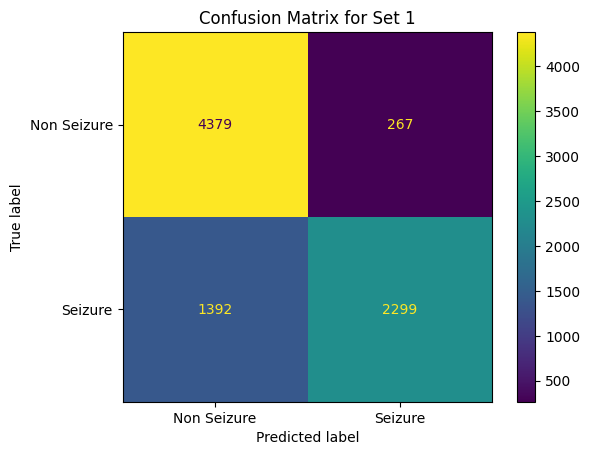

Input shape: (None, 18, 129, 1)
After Conv2D(32): (None, 16, 127, 32)
After MaxPooling2D: (None, 8, 63, 32)
After Conv2D(64): (None, 6, 61, 64)
After second MaxPooling2D: (None, 3, 30, 64)
After Conv2D(128): (None, 1, 28, 128)
After third MaxPooling2D: (None, 1, 14, 128)
After Flatten: (None, 1792)
After Dense(128): (None, 128)
After Dense(2): (None, 2)
Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.6947 - loss: 0.6030 - val_accuracy: 0.5181 - val_loss: 0.8081
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.7644 - loss: 0.4995 - val_accuracy: 0.5046 - val_loss: 0.8239
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.7980 - loss: 0.4468 - val_accuracy: 0.4918 - val_loss: 0.8937
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.8294 - loss: 0.3884 - val_accuracy: 0.3649 - val_loss: 1.5125
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.8481 - loss: 0.3539 - val_accuracy: 0.4651 - val_loss: 

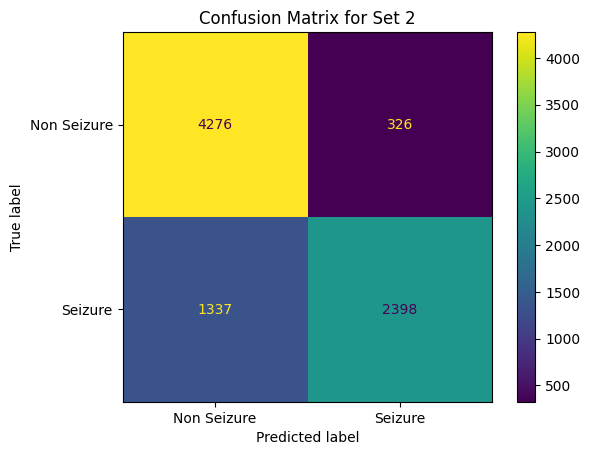

Input shape: (None, 18, 129, 1)
After Conv2D(32): (None, 16, 127, 32)
After MaxPooling2D: (None, 8, 63, 32)
After Conv2D(64): (None, 6, 61, 64)
After second MaxPooling2D: (None, 3, 30, 64)
After Conv2D(128): (None, 1, 28, 128)
After third MaxPooling2D: (None, 1, 14, 128)
After Flatten: (None, 1792)
After Dense(128): (None, 128)
After Dense(2): (None, 2)
Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - accuracy: 0.6896 - loss: 0.6203 - val_accuracy: 0.2942 - val_loss: 1.2636
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 76s 87ms/step - accuracy: 0.7586 - loss: 0.5021 - val_accuracy: 0.4315 - val_loss: 0.9721
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.7813 - loss: 0.4658 - val_accuracy: 0.2036 - val_loss: 2.0428
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.8149 - loss: 0.4233 - val_accuracy: 0.4135 - val_loss: 1.1145
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.8332 - loss: 0.3873 - val_accuracy: 0.3940 - val_loss: 

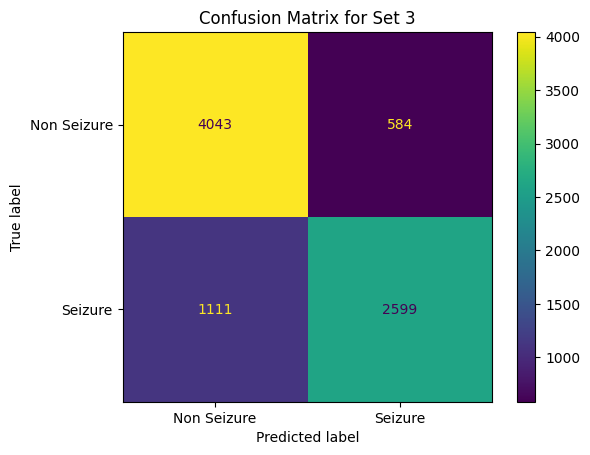

Test Accuracies: [0.8010075688362122, 0.8005277514457703, 0.7966894507408142]
Validation Accuracies: [0.6584707498550415, 0.578410804271698, 0.5799100399017334]
Validation Losses: [0.7389415502548218, 0.8081353902816772, 0.9113646745681763]
Train Losses: [0.17589452862739563, 0.10681285709142685, 0.09370063990354538]


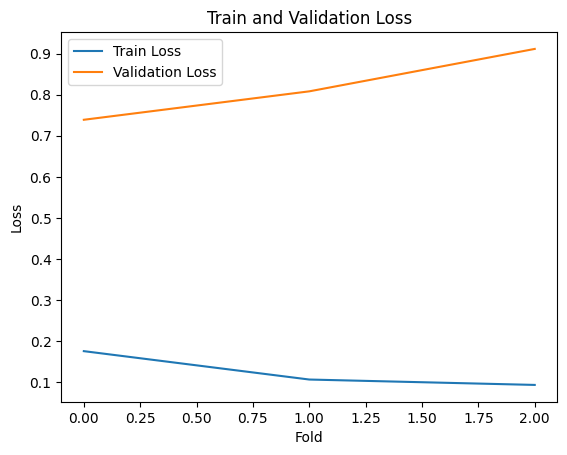

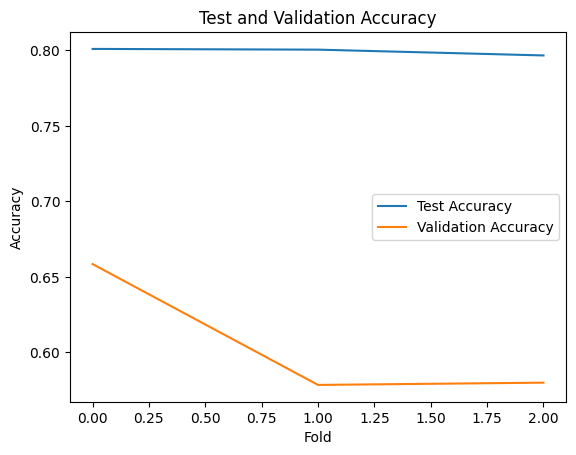

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

base_dir = r"/content/drive/MyDrive/EEG Signal Classification/cnn_dataset"
sets = ['set1', 'set2', 'set3']


def load_data():
    data = []
    labels = []
    for s in sets:
        for label, folder in enumerate(['non_seizure', 'seizure']):
            folder_path = os.path.join(base_dir, s, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.npy'):
                    file_path = os.path.join(folder_path, file)
                    array = np.load(file_path)
                    array = np.expand_dims(array, axis=-1)
                    data.append(array)
                    labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


data, labels = load_data()
labels = to_categorical(labels, num_classes=2)


def create_model(input_shape):
    inputs = Input(shape=input_shape)
    print(f"Input shape: {inputs.shape}")

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    print(f"After Conv2D(32): {x.shape}")

    x = MaxPooling2D((2, 2))(x)
    print(f"After MaxPooling2D: {x.shape}")

    x = Conv2D(64, (3, 3), activation='relu')(x)
    print(f"After Conv2D(64): {x.shape}")

    x = MaxPooling2D((2, 2))(x)
    print(f"After second MaxPooling2D: {x.shape}")

    x = Conv2D(128, (3, 3), activation='relu')(x)
    print(f"After Conv2D(128): {x.shape}")

    x = MaxPooling2D((1, 2))(x)
    print(f"After third MaxPooling2D: {x.shape}")

    x = Flatten()(x)
    print(f"After Flatten: {x.shape}")

    x = Dense(128, activation='relu')(x)
    print(f"After Dense(128): {x.shape}")

    outputs = Dense(2, activation='softmax')(x)
    print(f"After Dense(2): {outputs.shape}")

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


kf = KFold(n_splits=3, shuffle=True, random_state=42)
input_shape = data.shape[1:]

train_losses = []
val_losses = []
val_accuracies = []
test_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(data)):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    val_split = 0.2
    split_index = int(len(x_train) * (1 - val_split))
    x_train, x_val = x_train[:split_index], x_train[split_index:]
    y_train, y_val = y_train[:split_index], y_train[split_index:]

    model = create_model(input_shape)

    history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

    model_path = f'model_with_3cnnlayers_epchs20_split1_fold_{fold + 1}.keras'
    model.save(model_path)
    print(f"Model saved to {model_path}")

    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    val_accuracy = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])

    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    train_losses.append(train_loss)

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Seizure', 'Seizure'])
    disp.plot()
    plt.title(f"Confusion Matrix for Set {fold + 1}")
    plt.show()

print(f"Test Accuracies: {test_accuracies}")
print(f"Validation Accuracies: {val_accuracies}")
print(f"Validation Losses: {val_losses}")
print(f"Train Losses: {train_losses}")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

plt.figure()
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test and Validation Accuracy')
plt.show()
